In [1]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
data = pd.read_csv("C:/machine learning/Amazon Customer Behavior Survey.csv")

In [2]:
data_modified = data.copy()

mappings = {
    'Personalized_Recommendation_Frequency': {'Yes': 3, 'Sometimes': 2, 'No': 1},
    'Browsing_Frequency': {
        'Multiple times a day': 4,
        'Few times a week': 3,
        'Few times a month': 2,
        'Rarely': 1
    },
    'Cart_Completion_Frequency': {'Often': 3, 'Sometimes': 2, 'Rarely': 1},
    'Saveforlater_Frequency': {'Always': 5, 'Often': 4, 'Sometimes': 3, 'Rarely': 2, 'Never': 1},
    'Recommendation_Helpfulness': {'Yes': 3, 'Sometimes': 2, 'No': 1}
}

for column, mapping in mappings.items():
    data_modified[column] = data_modified[column].map(mapping)

data_modified.to_csv("C:/machine learning/Amazon Customer Behavior Survey Modified.csv", index=False)

print(data_modified.head())



                        Timestamp  age             Gender  \
0  2023/06/04 1:28:19 PM GMT+5:30   23             Female   
1  2023/06/04 2:30:44 PM GMT+5:30   23             Female   
2  2023/06/04 5:04:56 PM GMT+5:30   24  Prefer not to say   
3  2023/06/04 5:13:00 PM GMT+5:30   24             Female   
4  2023/06/04 5:28:06 PM GMT+5:30   22             Female   

       Purchase_Frequency                                Purchase_Categories  \
0       Few times a month                           Beauty and Personal Care   
1            Once a month                               Clothing and Fashion   
2       Few times a month    Groceries and Gourmet Food;Clothing and Fashion   
3            Once a month  Beauty and Personal Care;Clothing and Fashion;...   
4  Less than once a month      Beauty and Personal Care;Clothing and Fashion   

   Personalized_Recommendation_Frequency  Browsing_Frequency  \
0                                      3                   3   
1                       

In [3]:
print("Missing values before processing:\n", data.isnull().sum())
data = data.dropna()  # Drop rows with missing values
print("Missing values after processing:\n", data.isnull().sum())

label_encoder = LabelEncoder()
for column in data.select_dtypes(include=['object']).columns:
    data[column] = label_encoder.fit_transform(data[column])

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

Missing values before processing:
 Timestamp                                 0
age                                       0
Gender                                    0
Purchase_Frequency                        0
Purchase_Categories                       0
Personalized_Recommendation_Frequency     0
Browsing_Frequency                        0
Product_Search_Method                     2
Search_Result_Exploration                 0
Customer_Reviews_Importance               0
Add_to_Cart_Browsing                      0
Cart_Completion_Frequency                 0
Cart_Abandonment_Factors                  0
Saveforlater_Frequency                    0
Review_Left                               0
Review_Reliability                        0
Review_Helpfulness                        0
Personalized_Recommendation_Frequency     0
Recommendation_Helpfulness                0
Rating_Accuracy                           0
Shopping_Satisfaction                     0
Service_Appreciation                     

NaN counts in data_scaled: 0
Inf counts in data_scaled: 0
WSS: [13800.000000000013, 12375.00523290628, 11766.125989044465, 11333.372534368174, 10994.136156768738, 10709.796334524006, 10436.724256799389, 10253.56702087678, 10045.102911562784, 9870.236874340984]


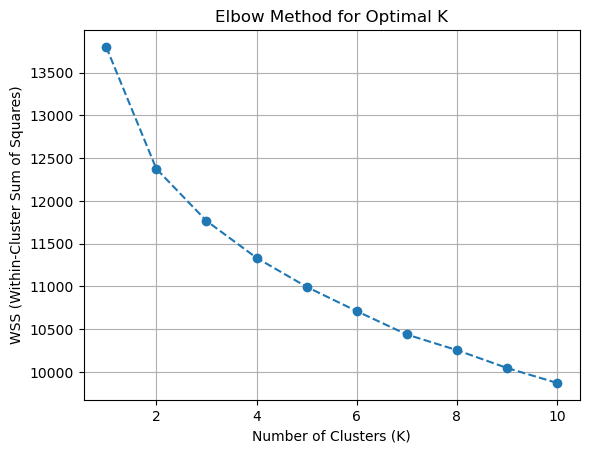

In [4]:
print("NaN counts in data_scaled:", np.isnan(data_scaled).sum())
print("Inf counts in data_scaled:", np.isinf(data_scaled).sum())

def calculate_WSS(data, kmax):
    if isinstance(data, pd.DataFrame):
        data = data.to_numpy()
    
    sse = []
    for k in range(1, kmax + 1):
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=42).fit(data)
        centroids = kmeans.cluster_centers_
        pred_clusters = kmeans.predict(data)
        curr_sse = 0
        
        for i in range(len(data)):
            curr_center = centroids[pred_clusters[i]]
            curr_sse += np.sum((data[i] - curr_center) ** 2)
            
        sse.append(curr_sse)
    return sse

if isinstance(data_scaled, pd.DataFrame):
    data_scaled = data_scaled.to_numpy()

WSS = calculate_WSS(data_scaled, 10)
print('WSS:', WSS)

plt.plot(range(1, 11), WSS, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.show()


In [5]:
data = data.copy() 
optimal_k = 3  
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(data_scaled)
data["Cluster"] = clusters


In [6]:
cluster_summary = data.groupby('Cluster').mean()
print(cluster_summary)

          Timestamp        age    Gender  Purchase_Frequency  \
Cluster                                                        
0        230.363636  29.100000  0.918182            1.590909   
1        386.339100  32.875433  0.871972            1.775087   
2        210.606965  28.686567  0.467662            1.562189   

         Purchase_Categories  Personalized_Recommendation_Frequency  \
Cluster                                                               
0                  12.718182                               0.609091   
1                   6.681661                               0.875433   
2                  12.507463                               0.756219   

         Browsing_Frequency  Product_Search_Method  Search_Result_Exploration  \
Cluster                                                                         
0                  1.490909                1.70000                   0.563636   
1                  0.820069                1.17301                   0.712803   

In [7]:
cluster_counts = data['Cluster'].value_counts()
print("Number of samples in each cluster:")
print(cluster_counts)

Number of samples in each cluster:
Cluster
1    289
2    201
0    110
Name: count, dtype: int64


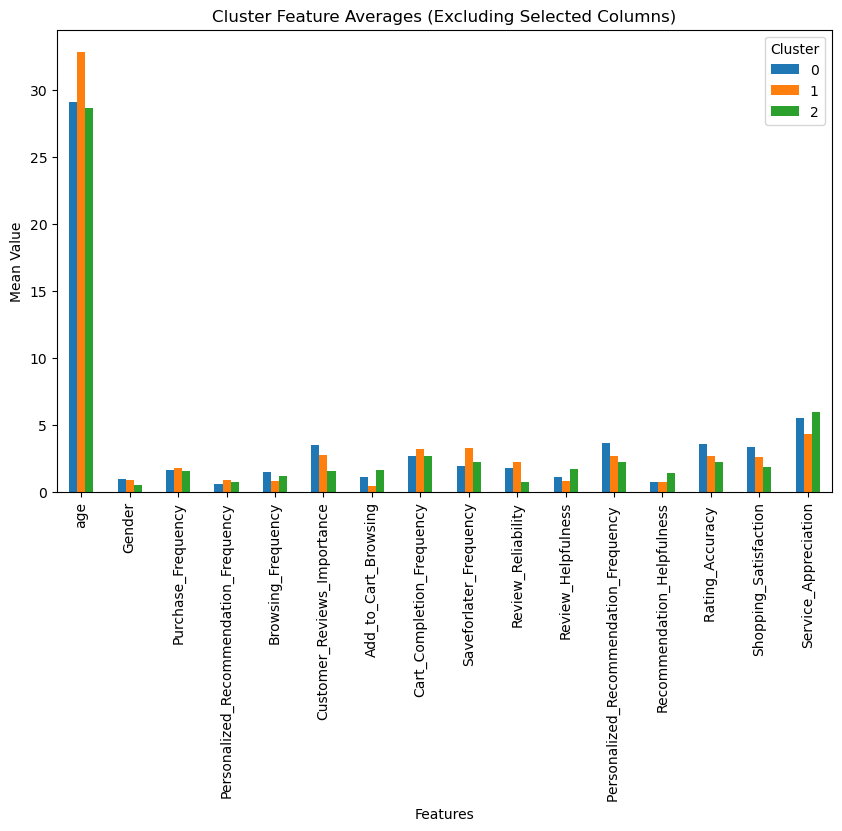

In [10]:
columns_to_exclude = [
    "Timestamp", 
    "Purchase_Categories", 
    "Product_Search_Method", 
    "Search_Result_Exploration", 
    "Cart_Abandonment_Factors", 
    "Review_Left", 
    "Improvement_Areas"
]

filtered_data = cluster_summary.drop(columns=columns_to_exclude)

filtered_data.T.plot(kind="bar", figsize=(10, 6))
plt.title("Cluster Feature Averages (Excluding Selected Columns)")
plt.ylabel("Mean Value")
plt.xlabel("Features")
plt.legend(title="Cluster")
plt.show()



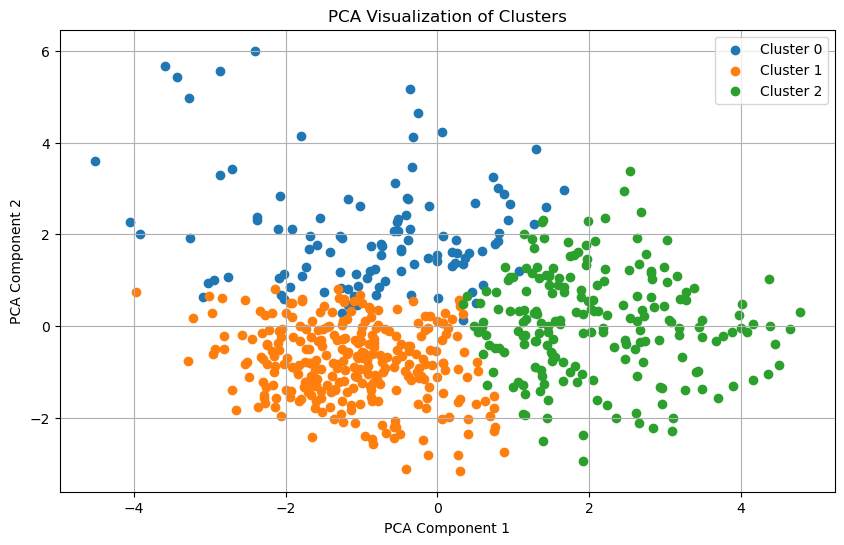

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensions to 2D using PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

plt.figure(figsize=(10, 6))
for cluster in range(optimal_k):
    plt.scatter(data_pca[clusters == cluster, 0], 
                data_pca[clusters == cluster, 1], 
                label=f"Cluster {cluster}")
plt.title("PCA Visualization of Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()
